In this notebook, I will add the missing roles in the temporary NoUniteD dataset

# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nuans_minihw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
datasets_root_path = './temp_files/'
srl_dataset_path = os.path.join(datasets_root_path, 'maven_nounited_srl')
checkpoints_dir_path = './checkpoints/'
model_dir_path = os.path.join(checkpoints_dir_path, 'other')

srl_dataset_dict_paths = {}
for lang in os.listdir(srl_dataset_path):
    dataset_lang_path = os.path.join(srl_dataset_path, lang)
    if os.path.isdir(dataset_lang_path):
        srl_dataset_dict_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            srl_dataset_dict_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = np.load(os.path.join(checkpoints_dir_path, 'models_nounited_maven', 'global_params.npy'), allow_pickle=True).tolist()

In [6]:
split_type = '_v'
max_length_train = None

## Training the role adder model

In [7]:
from code_files.datasets.dataset_nounited import DatasetNoUniteD

In [60]:
dataset_train_en_aic = DatasetNoUniteD(  
    srl_dataset_dict_paths['EN']['train'], 
    split_predicates=True, 
    split_type_to_use = split_type, 
    max_length = max_length_train, 
    shuffle = max_length_train != None )
    
dataset_dev_en_aic = DatasetNoUniteD(  
    srl_dataset_dict_paths['EN']['dev'], 
    split_predicates=True, 
    split_type_to_use = split_type, 
    max_length = int(max_length_train*0.2) if max_length_train != None else max_length_train, 
    shuffle = max_length_train != None )

In [9]:
len(dataset_train_en_aic.data), len(dataset_dev_en_aic.data)

(57749, 12558)

In [10]:
print(dataset_train_en_aic[0],'\n\n',dataset_dev_en_aic[0])

{'words': ['The', '2006', 'Pangandaran', 'earthquake', 'and', 'tsunami', 'occurred', 'on', 'July', '17', 'at', 'along', 'a', 'subduction', 'zone', 'off', 'the', 'coast', 'of', 'west', 'and', 'central', 'Java', ',', 'a', 'large', 'and', 'densely', 'populated', 'island', 'in', 'the', 'Indonesian', 'archipelago', '.'], 'predicates': ['_', '_', '_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_v': ['_', '_', '_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_n': ['_', '_', '_', 'MOVE-ONESELF', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'roles': ['_', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_'

In [11]:
from torch.utils.data import DataLoader

dataloader_train_en_aic = DataLoader(
    dataset_train_en_aic,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en_aic.create_collate_fn(),
    shuffle=True,
)

dataloader_dev_en_aic = DataLoader(
    dataset_dev_en_aic,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_en_aic.create_collate_fn(),
    shuffle=False,
)

In [12]:
for ex_in in dataloader_dev_en_aic:
    break

In [13]:
smpl_idx = 11
print(ex_in['words'][smpl_idx], '\n', ex_in['predicate_name'][smpl_idx], ex_in['predicate_word'][smpl_idx], '\n', ex_in['predicates_positions'][smpl_idx], '\n', ex_in['roles'][smpl_idx])

['Three', 'coaches', 'derailed', 'as', 'a', 'result', 'of', 'the', 'crash', 'while', 'another', 'caught', 'fire', '.'] 
 ['CATCH'] ['caught'] 
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 
 ['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'agent', '_', 'theme', '_']


In [14]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en_aic.predicates_pad_id) # !

In [15]:
from code_files.models.model_role_adder import ModelRoleAdder
from code_files.utils.utils_functions import print_summary
import torch.optim as optim

model_role = ModelRoleAdder(
    loss_fn = loss_function,
    hparams = global_params,
    fine_tune_transformer = True
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
optimizer_pid = optim.SGD(model_role.parameters(), lr=0.0016, momentum=0.9) 

In [17]:
print_summary(model_role, short=True)

parameters: 278,065,180
trainable parameters: 278,065,180
non-trainable parameters: 0


In [18]:
history = {}

In [19]:
from code_files.utils.Trainer_role_adder import Trainer_role_adder

trainer_role_adder = Trainer_role_adder()

history = trainer_role_adder.train(
    model_role, optimizer_pid, dataloader_train_en_aic, dataloader_dev_en_aic,
    epochs=100, device=device,
    save_best=True, 
    min_score=0.8,
    save_path_name=os.path.join(model_dir_path, f'role_adder_transformer_nounited{split_type}.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.174211
# Validation loss => 0.119662 | f1-score: arg_iden = 0.902784 arg_class = 0.557744 #
Epoch   1 => avg_loss: 0.104589
# Validation loss => 0.079626 | f1-score: arg_iden = 0.925935 arg_class = 0.739035 #
Epoch   2 => avg_loss: 0.078022
# Validation loss => 0.058964 | f1-score: arg_iden = 0.932426 arg_class = 0.816781 #
----- Best value obtained, saving model -----
Epoch   3 => avg_loss: 0.062675
# Validation loss => 0.051052 | f1-score: arg_iden = 0.939238 arg_class = 0.849665 #
----- Best value obtained, saving model -----
Epoch   4 => avg_loss: 0.053836
# Validation loss => 0.045781 | f1-score: arg_iden = 0.941145 arg_class = 0.860252 #
----- Best value obtained, saving model -----
Epoch   5 => avg_loss: 0.048366
# Validation loss => 0.043136 | f1-score: arg_iden = 0.944513 arg_class = 0.868138 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.045311
# Validation loss => 0.041909 | f1-score: arg_iden = 0.944811 arg_class = 0.870130

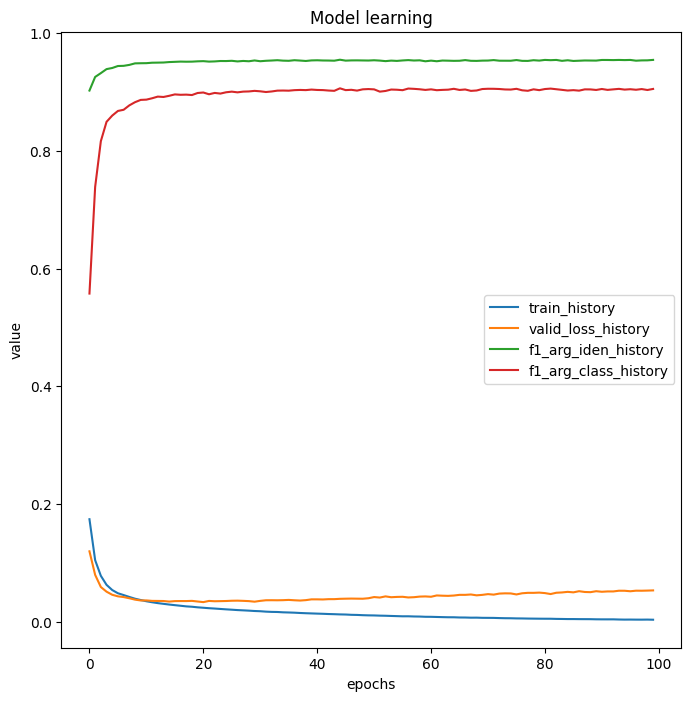

In [20]:
trainer_role_adder.display_history(history)

## Testing the model

In [72]:
from copy import deepcopy

In [9]:
from code_files.models.model_role_adder import ModelRoleAdder

model_role = ModelRoleAdder(
    hparams = global_params
)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
model_role.load_weights(os.path.join(model_dir_path, f'role_adder_transformer_nounited{split_type}.pth'))

In [82]:
smpl_num = 6
smpl = dataset_dev_en_aic[smpl_num]
print(smpl)

{'words': ['The', 'Penukonda', 'train', 'collision', 'occurred', 'in', 'the', 'early', 'hours', 'of', '22', 'May', '2012', ',', 'when', 'the', 'Bangalore', 'bound', 'Hampi', 'Express', 'crashed', 'into', 'a', 'stationary', 'freight', 'train', 'near', 'Penukonda', ',', 'in', 'the', 'Indian', 'state', 'of', 'Andhra', 'Pradesh', '.'], 'predicates': ['_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_v': ['_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'BREAK_DETERIORATE', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_n': ['_', '_', '_', 'HIT', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'roles': ['_', '_',

In [83]:
print(smpl['words'])
print(smpl['predicate_name'], smpl['predicate_position'])
print(smpl['roles'])

['The', 'Penukonda', 'train', 'collision', 'occurred', 'in', 'the', 'early', 'hours', 'of', '22', 'May', '2012', ',', 'when', 'the', 'Bangalore', 'bound', 'Hampi', 'Express', 'crashed', 'into', 'a', 'stationary', 'freight', 'train', 'near', 'Penukonda', ',', 'in', 'the', 'Indian', 'state', 'of', 'Andhra', 'Pradesh', '.']
['HAPPEN_OCCUR'] [4]
['_', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


In [84]:
print('Sentence:',' '.join(smpl['words']))
print('Predicate:',smpl['predicate_word'][0], '->', smpl['predicate_name'][0])
for w, r in zip(smpl['words'],smpl['roles']):
    if r != '_':
        print(w,'->',r)

Sentence: The Penukonda train collision occurred in the early hours of 22 May 2012 , when the Bangalore bound Hampi Express crashed into a stationary freight train near Penukonda , in the Indian state of Andhra Pradesh .
Predicate: occurred -> HAPPEN_OCCUR
collision -> theme


In [85]:
print(
    model_role.predict(
        deepcopy(smpl['words']), 
        smpl['predicate_position'][0], 
        smpl['predicate_name'][0]
    )[0]
)

['_', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


## Checking if it can be used for nominal

In [86]:
smpl_num = 6
smpl = dataset_dev_en_aic[smpl_num]

In [87]:
for i, (w, pn) in enumerate( zip(smpl['words'], smpl['predicates_n']) ):
    if pn != '_':
        print('Predicate:',w, '->', pn)
        roles_res = model_role.predict(
            deepcopy(smpl['words']),
            i, 
            pn
        )[0]
        print(roles_res)
        break

Predicate: collision -> HIT
['_', '_', 'agent', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']


## Implementing the final annotations

In [88]:
import json

with open(srl_dataset_dict_paths['EN']['train']) as json_file:
    nounited_en_train = json.load(json_file)

with open(srl_dataset_dict_paths['EN']['dev']) as json_file:
    nounited_en_dev = json.load(json_file)

In [92]:
for nounited_split in [nounited_en_train, nounited_en_dev]:
    for sample in nounited_split:
        for i, (w, pn) in enumerate( zip(sample['words'], sample['predicates_n']) ):
            if pn != '_':
                roles_res = model_role.predict(
                    deepcopy(sample['words']),
                    i, 
                    pn
                )[0]
                sample['roles_n'][str(i)] = roles_res

In [104]:
print(nounited_en_dev[3])

{'words': ['The', 'Penukonda', 'train', 'collision', 'occurred', 'in', 'the', 'early', 'hours', 'of', '22', 'May', '2012', ',', 'when', 'the', 'Bangalore', 'bound', 'Hampi', 'Express', 'crashed', 'into', 'a', 'stationary', 'freight', 'train', 'near', 'Penukonda', ',', 'in', 'the', 'Indian', 'state', 'of', 'Andhra', 'Pradesh', '.'], 'predicates': ['_', '_', '_', 'HIT', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'BREAK_DETERIORATE', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_v': ['_', '_', '_', '_', 'HAPPEN_OCCUR', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'BREAK_DETERIORATE', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 'predicates_n': ['_', '_', '_', 'HIT', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], '

In [107]:
no_roles_found = 0
for ssmpl in nounited_en_dev:
    for i, (w, pn) in enumerate( zip(ssmpl['words'], ssmpl['predicates_n']) ):
        if pn != '_':
            print('Sentence:', ssmpl['words'])
            print('Predicate:',w, '->', pn)
            if all([r == '_' for r in ssmpl['roles_n'][str(i)]]):
                print('No roles found!')
                no_roles_found += 1
            else:
                for r_i, r in enumerate(ssmpl['roles_n'][str(i)]):
                    if r != '_':
                        print(ssmpl['words'][r_i],'->',ssmpl['roles_n'][str(i)][r_i])

Sentence: ['Since', '1916', 'the', 'anniversary', 'of', 'the', 'landings', 'on', '25', 'April', 'has', 'been', 'commemorated', 'as', 'Anzac', 'Day', ',', 'becoming', 'one', 'of', 'the', 'most', 'important', 'national', 'celebrations', 'in', 'Australia', 'and', 'New', 'Zealand', '.']
Predicate: landings -> LAND_GET-OFF
No roles found!
Sentence: ['The', 'Penukonda', 'train', 'collision', 'occurred', 'in', 'the', 'early', 'hours', 'of', '22', 'May', '2012', ',', 'when', 'the', 'Bangalore', 'bound', 'Hampi', 'Express', 'crashed', 'into', 'a', 'stationary', 'freight', 'train', 'near', 'Penukonda', ',', 'in', 'the', 'Indian', 'state', 'of', 'Andhra', 'Pradesh', '.']
Predicate: collision -> HIT
train -> agent
Sentence: ['Three', 'coaches', 'derailed', 'as', 'a', 'result', 'of', 'the', 'crash', 'while', 'another', 'caught', 'fire', '.']
Predicate: crash -> BREAK_DETERIORATE
No roles found!
Sentence: ['Three', 'coaches', 'derailed', 'as', 'a', 'result', 'of', 'the', 'crash', 'while', 'another',

In [109]:
f"{no_roles_found}/{len(nounited_en_dev)}"

'1490/6143'

In [105]:
out_dir = os.path.join('datasets','maven_nounited_srl','EN')
os.makedirs(out_dir)

In [106]:
with open(os.path.join(out_dir,'train.json'), 'w') as fout:
    json.dump(nounited_en_train, fout, indent=4)

with open(os.path.join(out_dir,'dev.json'), 'w') as fout:
    json.dump(nounited_en_dev, fout, indent=4)